In [1]:
import pyro
import torch
import wandb
import os

from inference.bayesian.models import TorchModel, HorseshoeSSVS
from inference.bayesian.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

In [2]:
config = {
            "dataset": "acea",
            "model_widths": [50, 10, 1],
            "activation": "tanh",
            "distributions": ["gauss", "unif", "gauss"],
            "parameters": [[0,1],[0,10]],
            "dim_reduction": False,
            "inference": "mcmc",
            "lr": 0.03,
            "num_iterations": 120,
            "quantile": 0.95,
            "plot": True
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Run ESN on dataset and produce embeddings with or without dimensionality reduction according to `dim_reduction`

In [4]:
Ytr, train_embedding, val_embedding, Yte, test_embedding = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 4882, Val: 1047, Te: 1047


# Stochastic Search Variable Selection


Perform SSVS on embeddings with no dimensionality reduction.

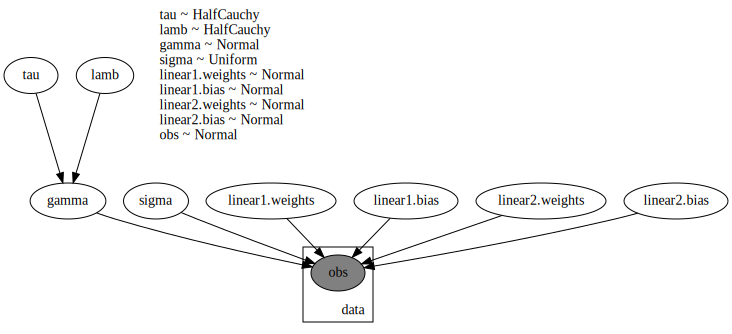

In [5]:
# Define the horseshoe SSVS model
# type = 'm' for 'manual' linear layer, type = 't' for torch.nn.linear
ssvs_model = HorseshoeSSVS(train_embedding.shape[1], 1, type='m', device=device)

pyro.render_model(ssvs_model, model_args=(train_embedding[0], Ytr[0]), render_distributions=True, filename=None)

In [6]:
# Run Markov chains and collect diagnostics
num_samples = 2000
ssvs_mcmc, predictive, diagnostics = inference(config, ssvs_model, None, X_train=train_embedding, Y_train=Ytr, 
                                            X_test=test_embedding, Y_test=Yte, num_samples=num_samples, inference_name="ssvs")

Sample: 100%|██████████| 2000/2000 [13:28,  2.47it/s, step size=1.95e-03, acc. prob=0.021]


MCMC run time: 0.07708333333333334 minutes.
MCMC converged at 1797 steps.


<Figure size 600x600 with 0 Axes>

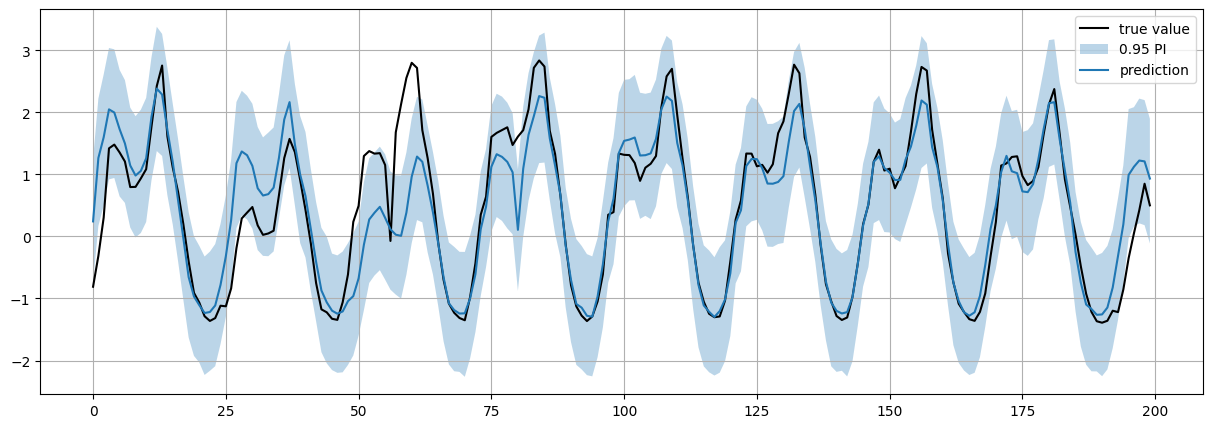

In [7]:
plot_forecast(predictive, Yte, "ssvs")

In [8]:
for k, v in diagnostics.items():
    print(k)

step_size
acceptance_rate
train_time
effective_sample_size
split_gelman_rubin
autocorrelation
quantiles
cal_error
crps


In [8]:
print("training time: ", diagnostics['train_time'])
print("effective sample size: ", diagnostics['effective_sample_size'])
print("calibration error: ", diagnostics['cal_error'])
print("Continuous ranked probability score: ", diagnostics['crps'])

training time:  4.625
effective sample size:  tensor(13.4470, device='cuda:0')
calibration error:  5.9108024619415644
Continuous ranked probability score:  0.2485315054655075


In [21]:
# to reload a package or method
import sys, importlib

importlib.reload(sys.modules['bayesian.utils'])

from inference.bayesian.utils import plot_forecast

In [23]:
# to save a session
import dill

dill.dump_session('dump/notebook_16122022.db')

In [ ]:
# to load a session
dill.load_session('notebook_env.db')